In [8]:
import numpy as np
import pandas as pd
import yfinance as yf
from statistics import stdev
import matplotlib.pyplot as plt
from collections import defaultdict
from statistics import stdev, mean
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

In [9]:
def take(series, i):
    return [x[i] for x in series]

def first(series):
    return take(series, 0)

def second(series):
    return take(series, 1)

def extract_series(df, ticker, metric):
    return list(zip(list(df.index.astype(str)), list(df_tech[metric][ticker])))

def daily_returns(series):
    return [(series[index][0], (series[index][1] - series[index-1][1]) / series[index-1][1]) for index in range(1, len(series))]

def log_returns(series):
    return [(item[0], log(item[1])) for item in series]

def execute_strategy(prices, take_profit_price, stop_loss_price):
    for daily_price in prices:
        if daily_price >= take_profit_price:
            return take_profit_price
        if daily_price <= stop_loss_price:
            return stop_loss_price
    return prices[-1]

def strategy_returns(series, position_length, take_profit, stop_loss, max_price=None):
    returns = []
    prices = second(series) # extract prices
    for i, start_price in enumerate(prices[:-position_length]):
        if max_price is not None and start_price >= max_price:
            continue
        final_price = execute_strategy(
            prices=prices[i+1:i+1+position_length],
            take_profit_price=start_price*take_profit,
            stop_loss_price=start_price*stop_loss
        )
        r = (final_price - start_price) / start_price
        returns.append(r)
    trading_ratio = len(returns)/(len(series)-position_length)
    return list(zip([x[0] for x in series], returns)), trading_ratio

def bucketize(series, group_by, compute_func=lambda x:x):
    buckets = defaultdict(lambda: [])
    for (day, r) in series:
        buckets[group_by(day)].append(r)
    return [(key, compute_func(value)) for (key, value) in buckets.items()]

In [10]:
strategy_returns([(1, 1), (2, 2), (3, 3), (4, 4)], 2, take_profit=1.5, stop_loss=0.5, max_price=None)

([(1, 0.5), (2, 0.5)], 1.0)

[*********************100%***********************]  5 of 5 completed

1 Failed download:
['MSFT']: OperationalError('database is locked')


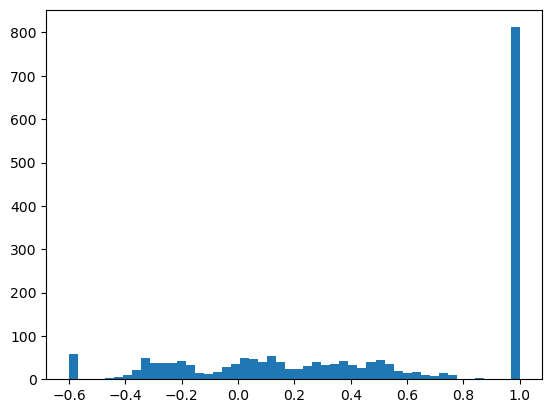

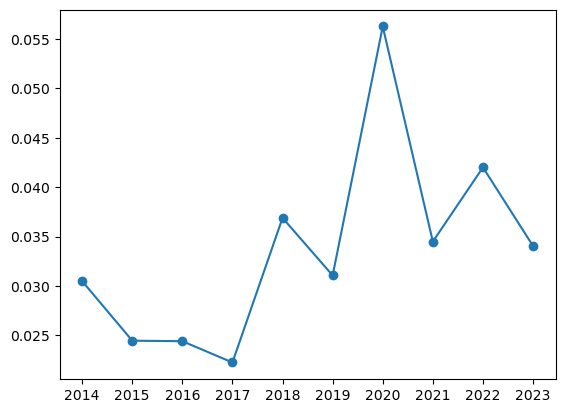

In [11]:
tickers = ['AAPL', 'MSFT', 'TSLA', 'META', 'GOOG']
df_tech = yf.download(tickers, '2014-01-01', '2023-12-31') # last 10 years

year_days = 262
ticker = 'TSLA'
metric = 'Adj Close'
s = extract_series(df_tech, ticker, metric)
daily_rets = daily_returns(s)
strategy_rets, _ = strategy_returns(s, position_length=2*year_days, take_profit=2, stop_loss=0.4)
daily_rets_per_year = bucketize(daily_rets, group_by=lambda s: s[:4], compute_func=stdev)
pf1 = plt.figure(1)
plt.hist(second(strategy_rets), bins=50)
pf1.show()
pf2 = plt.figure(2)
plt.plot(first(daily_rets_per_year), second(daily_rets_per_year), marker='o')
pf2.show()

In [5]:
tickers = ['AAPL', 'MSFT', 'TSLA', 'META', 'GOOG']
df_tech = yf.download(tickers, '2019-01-01', '2023-12-31') # last 5 years

[*********************100%%**********************]  5 of 5 completed


In [6]:
position_length=1*year_days
take_profit=1.50
stop_loss=0.5
max_price = None
print(f'PARAMS: take profit={take_profit:.2f}, stop loss={stop_loss:.2f}, position length={position_length}, max price={max_price}')
for ticker in tickers:
    strategy_rets, trading_ratio = strategy_returns(
        extract_series(df_tech, ticker=ticker, metric='Adj Close'),
        position_length=position_length,
        take_profit=take_profit,
        stop_loss=stop_loss,
        max_price=max_price,
    )
    win_rate = mean([int(r > 0) for r in second(strategy_rets)])
    avg_return = mean([r for r in second(strategy_rets)])
    avg_return_cond_win = mean([r for r in second(strategy_rets) if r > 0])
    print(f'ticker={ticker} -> trading ratio={trading_ratio:.2f}, win rate={win_rate:.2f}, avg return={avg_return:.2f}, when winning={avg_return_cond_win:.2f}')

PARAMS: take profit=1.50, stop loss=0.50, position length=262, max price=None
ticker=AAPL -> trading ratio=1.00, win rate=0.88, avg return=0.30, when winning=0.35
ticker=MSFT -> trading ratio=1.00, win rate=0.81, avg return=0.29, when winning=0.39
ticker=TSLA -> trading ratio=1.00, win rate=0.72, avg return=0.21, when winning=0.48
ticker=META -> trading ratio=1.00, win rate=0.63, avg return=0.08, when winning=0.38
ticker=GOOG -> trading ratio=1.00, win rate=0.73, avg return=0.19, when winning=0.34


In [59]:
tickers = ['AAPL', 'MSFT', 'TSLA', 'META', 'GOOG', 'TEAM', 'ASAN']
df_tech = yf.download(tickers, '2022-01-01', '2024-09-30') # study interval
position_length=1*year_days
take_profit=1.50
stop_loss=0.5
print(f'PARAMS: take profit={take_profit:.2f}, stop loss={stop_loss:.2f}, position length={position_length}')
for ticker in tickers:
    s = extract_series(df_tech, ticker=ticker, metric='Adj Close')
    max_price = mean(second(s))
    strategy_rets, trading_ratio = strategy_returns(s,
        position_length=position_length,
        take_profit=take_profit,
        stop_loss=stop_loss,
        max_price=max_price,
    )
    win_rate = mean([int(r > 0) for r in second(strategy_rets)])
    avg_return = mean([r for r in second(strategy_rets)])
    avg_return_cond_win = mean([r for r in second(strategy_rets) if r > 0])
    print(f'ticker={ticker}, max price={max_price:.1f} -> trading ratio={trading_ratio:.2f}, win rate={win_rate:.2f}, avg return={avg_return:.2f}, when winning={avg_return_cond_win:.2f}')

[*********************100%***********************]  7 of 7 completed


PARAMS: take profit=1.50, stop loss=0.50, position length=262
ticker=AAPL, max price=171.6 -> trading ratio=0.76, win rate=0.87, avg return=0.18, when winning=0.22
ticker=MSFT, max price=322.6 -> trading ratio=0.85, win rate=0.82, avg return=0.29, when winning=0.38
ticker=TSLA, max price=229.2 -> trading ratio=0.42, win rate=0.73, avg return=0.26, when winning=0.46
ticker=META, max price=291.1 -> trading ratio=0.85, win rate=0.74, avg return=0.24, when winning=0.50
ticker=GOOG, max price=129.1 -> trading ratio=0.78, win rate=0.95, avg return=0.33, when winning=0.35
ticker=TEAM, max price=197.4 -> trading ratio=0.59, win rate=0.81, avg return=0.35, when winning=0.45
ticker=ASAN, max price=21.7 -> trading ratio=0.57, win rate=0.61, avg return=0.13, when winning=0.37


In [52]:
def plot_win_rate(df, ticker, metric, position_length=1*year_days,
                  take_profits = [1.10, 1.20, 1.30, 1.40, 1.50],
                  stop_losses = [0.25, 0.50, 0.75],
                  max_price=None
                 ):
    results = defaultdict(lambda: [])
    s = extract_series(df, ticker, metric)
    for take_profit in take_profits:
        for stop_loss in stop_losses:
            strategy_rets, trading_ratio = strategy_returns(s, position_length, take_profit, stop_loss, max_price)
            win_ratio = mean([int(r > 0) for r in second(strategy_rets)])
            results[stop_loss].append((take_profit, win_ratio))
    # plot:
    legends = []
    for stop_loss, li in results.items():
        legends.append(f'stop loss={stop_loss:.2f}')
        plt.plot(first(li), second(li), marker='o')
    plt.title(f'{ticker}, max price={max_price}, trading ratio={trading_ratio:.2f}')
    plt.xlabel('take profit')
    plt.ylabel('win ratio')
    plt.ylim((-0.05, 1.05))
    plt.legend(legends)

def plot_win_return(df, ticker, metric, position_length=1*year_days,
                  take_profits = [1.10, 1.20, 1.30, 1.40, 1.50],
                  stop_losses = [0.25, 0.50, 0.75],
                  max_price=None
                 ):
    results = defaultdict(lambda: [])
    s = extract_series(df, ticker, metric)
    for take_profit in take_profits:
        for stop_loss in stop_losses:
            strategy_rets, trading_ratio = strategy_returns(s, position_length, take_profit, stop_loss, max_price)
            win_return = mean([r for r in second(strategy_rets) if r > 0])
            results[stop_loss].append((take_profit, win_return))
    # plot:
    legends = []
    for stop_loss, li in results.items():
        legends.append(f'stop loss={stop_loss:.2f}')
        plt.plot(first(li), second(li), marker='o')
    plt.title(f'{ticker}, max price={max_price}, trading ratio={trading_ratio:.2f}')
    plt.xlabel('take profit')
    plt.ylabel('mean win returns')
    plt.ylim((-0.05, 1.05))
    plt.legend(legends)

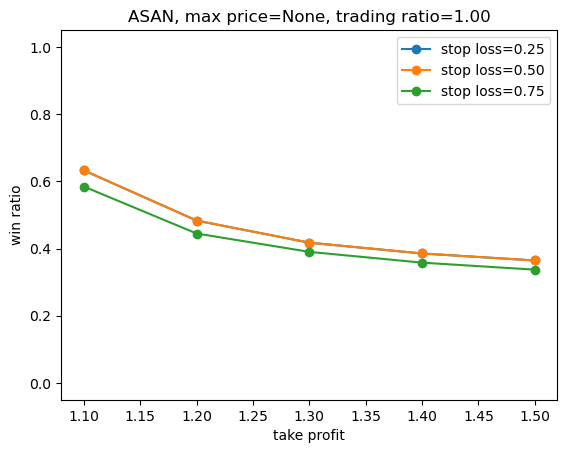

In [60]:
plot_win_rate(df_tech, position_length=int(0.25*year_days), ticker='ASAN', metric='Adj Close', max_price=None)

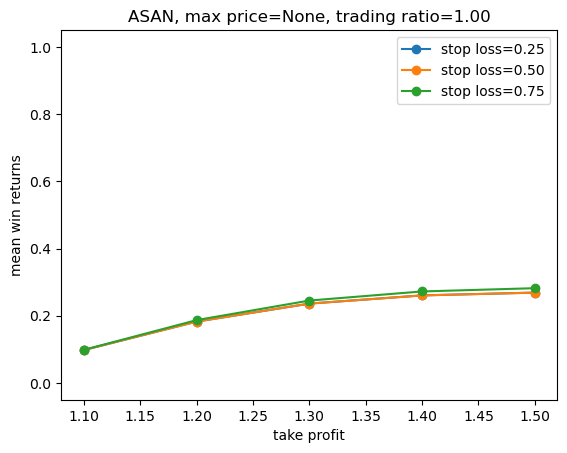

In [61]:
plot_win_return(df_tech, position_length=int(0.25*year_days), ticker='ASAN', metric='Adj Close', max_price=None)

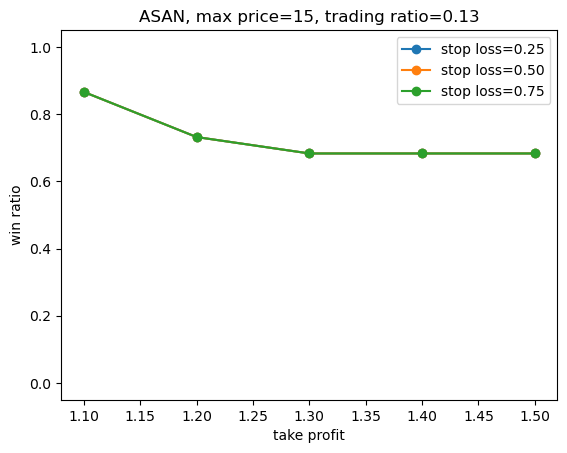

In [72]:
plot_win_rate(df_tech, position_length=int(0.25*year_days), ticker='ASAN', metric='Adj Close', max_price=15)

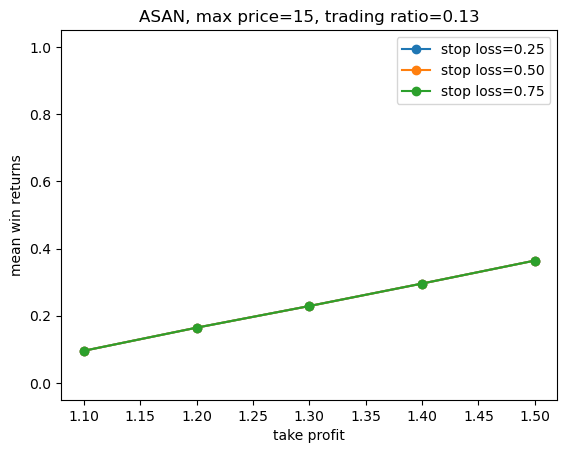

In [73]:
plot_win_return(df_tech, position_length=int(0.25*year_days), ticker='ASAN', metric='Adj Close', max_price=15)